# 📘 N-gram Language Model — Full Theory + Implementation (with Interpolation)

In [12]:
# Import the random module for generating random numbers,
# which can be useful for sampling or shuffling tokens.
import random

# Import the math module for mathematical operations
# (e.g., logarithms, exponentiation, probabilities).
import math

# Import Counter from collections to easily count the frequency
# of n-grams and contexts in the language model.
from collections import Counter

# Import List, Tuple, and Dict from typing to provide
# type hints for function parameters and return values.
from typing import List, Tuple, Dict

### 🔹 **Theory**

Before we can model language statistically, we must represent text as discrete **tokens** (usually words).
Tokenization is the process of splitting sentences into individual words or symbols.
Adding special tokens:

* `<s>` marks the **start of a sentence**
* `</s>` marks the **end of a sentence**

This helps the model learn context boundaries, so it doesn’t mix tokens from different sentences.

### 🔹 **Function**

## 🧩 1. Tokenization and Preprocessing


In [13]:
def tokenize_text(text: str) -> List[str]:
    """
    Theory:
    Converts raw text into tokens that the language model can process.
    It splits text into sentences, lowercases words for normalization,
    and inserts start (<s>) and end (</s>) markers around each sentence.

    Practical importance:
    - Enables the model to learn where sentences begin and end.
    - Normalizes text to reduce vocabulary sparsity.
    """
    # Split the input text into sentences using '.' as a delimiter
    # and remove any leading/trailing spaces from each sentence
    sentences = [s.strip() for s in text.split('.') if s.strip()]

    # Initialize an empty list to hold all tokens
    tokens = []

    # Loop through each sentence in the text
    for s in sentences:
        # Convert the sentence to lowercase for normalization
        words = s.lower().split()

        # Add special start and end markers around each sentence
        # <s> indicates the start of a sentence, </s> indicates the end
        tokens.extend(["<s>"] + words + ["</s>"])

    # Return the complete list of tokens
    return tokens

In [14]:
tokens = tokenize_text("This is a sample sentence. It has multiple words.")
tokens

['<s>',
 'this',
 'is',
 'a',
 'sample',
 'sentence',
 '</s>',
 '<s>',
 'it',
 'has',
 'multiple',
 'words',
 '</s>']

## 🧩 2. Building N-grams

### 🔹 **Theory**

An **N-gram** is a contiguous sequence of (N) items (usually words).
For example, for “I love AI”:

* Unigrams (N=1): I, love, AI
* Bigrams (N=2): (I, love), (love, AI)
* Trigrams (N=3): (I, love, AI)

These sequences capture **local word dependencies** — how likely a word is to follow a specific context.

### 🔹 **Function**

In [15]:
def build_ngrams(tokens: List[str], n: int) -> List[Tuple[str, ...]]:
    """
    Theory:
    Generates n-grams from a list of tokens.
    Each n-gram represents a potential local context used for probability estimation.

    Example:
        tokens = ["I", "love", "AI"]
        n=2 → [("I","love"), ("love","AI")]

    Purpose:
    - Helps us measure how often specific word patterns occur in the corpus.
    """
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

In [16]:
build_ngrams(tokens, 2)

[('<s>', 'this'),
 ('this', 'is'),
 ('is', 'a'),
 ('a', 'sample'),
 ('sample', 'sentence'),
 ('sentence', '</s>'),
 ('</s>', '<s>'),
 ('<s>', 'it'),
 ('it', 'has'),
 ('has', 'multiple'),
 ('multiple', 'words'),
 ('words', '</s>')]

In [17]:
build_ngrams(tokens, 3)

[('<s>', 'this', 'is'),
 ('this', 'is', 'a'),
 ('is', 'a', 'sample'),
 ('a', 'sample', 'sentence'),
 ('sample', 'sentence', '</s>'),
 ('sentence', '</s>', '<s>'),
 ('</s>', '<s>', 'it'),
 ('<s>', 'it', 'has'),
 ('it', 'has', 'multiple'),
 ('has', 'multiple', 'words'),
 ('multiple', 'words', '</s>')]

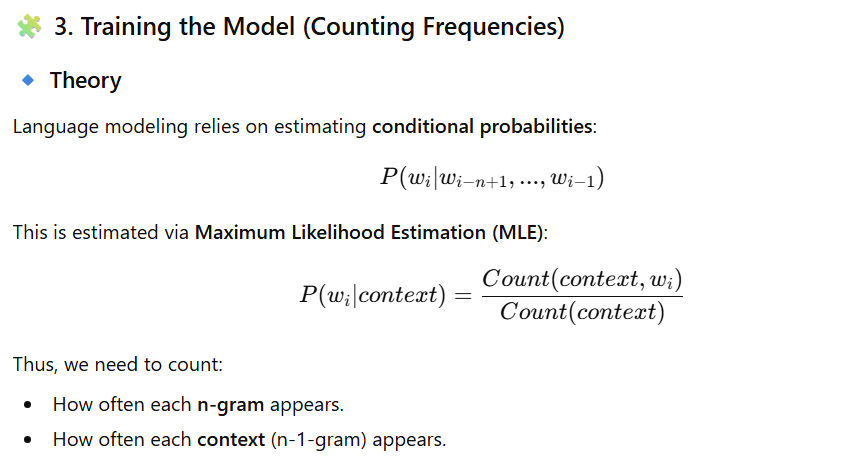

### 🔹 **Function**

In [18]:
def train_ngram_model(tokens: List[str], n: int) -> Tuple[Dict[Tuple[str, ...], int], Dict[Tuple[str, ...], int]]:
    """
    Theory:
    - Collect frequency counts for n-grams and their (n-1)-gram contexts.
    - These counts are the empirical statistics from which we estimate probabilities.

    Importance:
    - The counts form the 'memory' of our language model.
    - They are later used for both smoothing and interpolation.

    Returns:
        ngram_counts   → frequency of each n-gram
        context_counts → frequency of each (n-1)-gram context
    """
    # Step 1: Build all n-grams from the tokenized text
    # Example for n=3: ("<s>", "i", "am"), ("i", "am", "happy"), ...
    # Count how many times each unique n-gram appears
    ngram_counts = Counter(build_ngrams(tokens, n))

    # Step 2: Build all (n-1)-grams (contexts for n-grams)
    # Example for n=3, context = ("<s>", "i"), ("i", "am"), ...
    # These context counts help compute conditional probabilities later
    context_counts = Counter(build_ngrams(tokens, n - 1))

    # Step 3: Return both dictionaries:
    # - ngram_counts: frequency of each n-gram
    # - context_counts: frequency of each (n-1)-gram
    return ngram_counts, context_counts

In [19]:
ngram_counts, context_counts = train_ngram_model(tokens, 2)

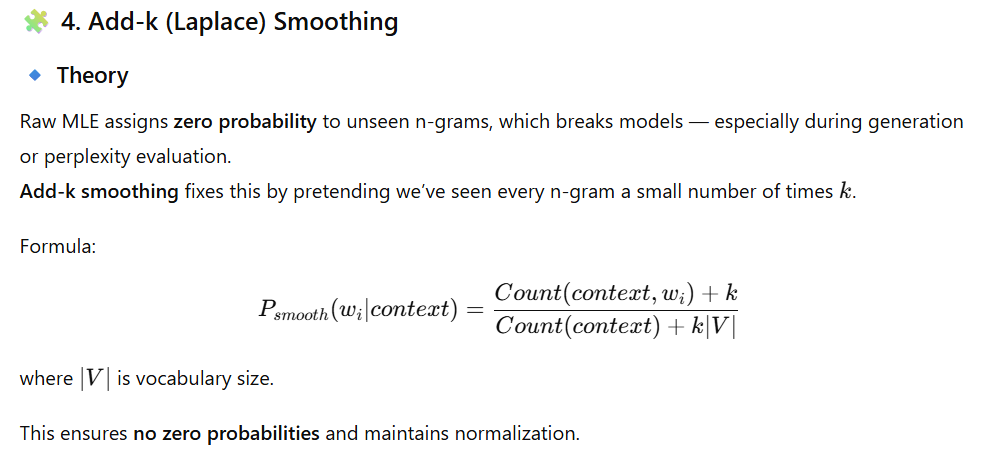

### 🔹 **Function**


In [20]:
def smoothed_probability(
    ngram: Tuple[str, ...],
    ngram_counts: Dict,
    context_counts: Dict,
    vocab_size: int,
    k: float = 1.0
) -> float:
    """
    Computes the smoothed probability of an n-gram using Laplace (Add-k) smoothing.
    """

    # Extract the context (all words except the last one)
    # Example: if ngram = ("i", "love"), then context = ("i",)
    context = ngram[:-1]

    # Compute the numerator:
    #   count of the n-gram + k
    # Adding k ensures unseen n-grams still get a small nonzero probability
    numerator = ngram_counts.get(ngram, 0) + k

    # Compute the denominator:
    #   count of the context + k * vocab_size
    # The term k * vocab_size redistributes some probability mass
    # across all possible next words in the vocabulary
    denominator = context_counts.get(context, 0) + k * vocab_size

    # Return the smoothed probability of this n-gram
    # Formula: P(w_n | context) = (count(ngram) + k) / (count(context) + k * |V|)
    return numerator / denominator


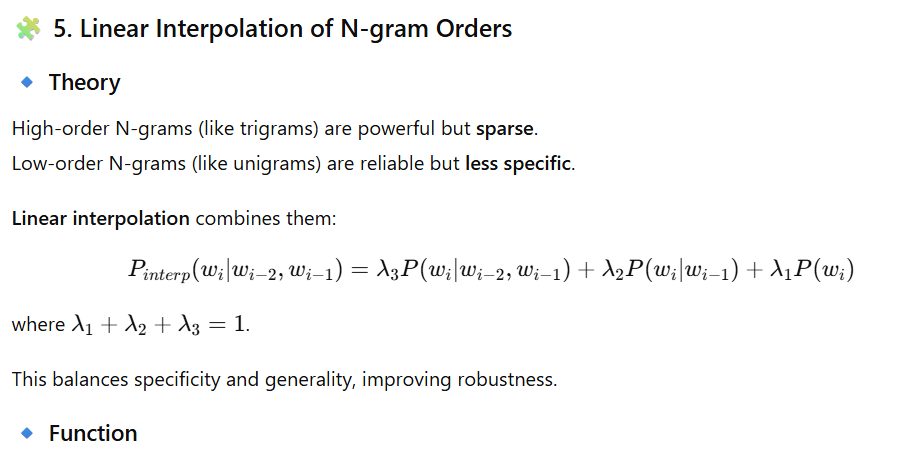

In [21]:
from typing import Tuple, Dict

def interpolated_probability(
    ngram: Tuple[str, ...],
    uni_counts: Dict,
    bi_counts: Dict,
    tri_counts: Dict,
    uni_contexts: Dict,
    bi_contexts: Dict,
    tri_contexts: Dict,
    vocab_size: int,
    lambdas: Tuple[float, float, float] = (0.1, 0.3, 0.6),
    k: float = 1.0
) -> float:
    """
    Computes the final probability of a trigram using interpolation
    between unigram, bigram, and trigram probabilities.
    """

    # Extract unigram, bigram, and trigram versions of the input n-gram
    # Example: if ngram = ("i", "love", "nlp")
    #   unigram = ("nlp",)
    #   bigram  = ("love", "nlp")
    #   trigram = ("i", "love", "nlp")
    unigram = (ngram[-1],)
    bigram = ngram[-2:]
    trigram = ngram

    # Compute smoothed probabilities for each model order
    # Unigram → single word probability
    p1 = smoothed_probability(unigram, uni_counts, uni_contexts, vocab_size, k)
    # Bigram → conditional probability of last word given previous one
    p2 = smoothed_probability(bigram, bi_counts, bi_contexts, vocab_size, k)
    # Trigram → conditional probability of last word given two previous ones
    p3 = smoothed_probability(trigram, tri_counts, tri_contexts, vocab_size, k)

    # Unpack interpolation weights (λ1, λ2, λ3)
    # These control how much influence each model order has
    λ1, λ2, λ3 = lambdas

    # Compute the final interpolated probability
    # Formula: P = λ1 * P_unigram + λ2 * P_bigram + λ3 * P_trigram
    # Ensures robust probabilities even for unseen higher-order n-grams
    return λ1 * p1 + λ2 * p2 + λ3 * p3


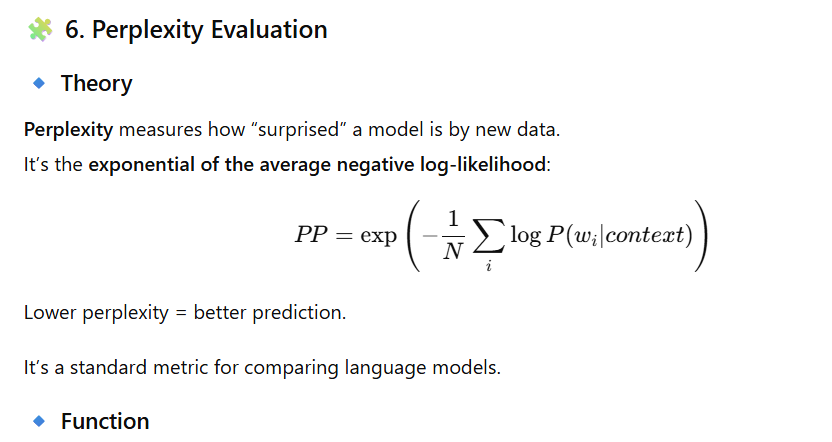

In [22]:
def calculate_perplexity_interpolated(
    test_tokens: List[str],
    uni_counts: Dict,
    bi_counts: Dict,
    tri_counts: Dict,
    uni_contexts: Dict,
    bi_contexts: Dict,
    tri_contexts: Dict,
    vocab_size: int,
    lambdas: Tuple[float, float, float] = (0.1, 0.3, 0.6),
    k: float = 1.0
) -> float:
    """
    Calculates the perplexity of a language model that uses interpolated
    unigram, bigram, and trigram probabilities.
    Lower perplexity → better model generalization.
    """

    # Step 1: Build all trigrams from the test token sequence
    # Example: ["<s>", "i", "love", "nlp", "</s>"]
    # → [("<s>", "i", "love"), ("i", "love", "nlp"), ("love", "nlp", "</s>")]
    test_trigrams = build_ngrams(test_tokens, 3)

    # Step 2: Initialize variable to accumulate the sum of log probabilities
    log_prob_sum = 0

    # Step 3: Loop through each trigram in the test data
    for ngram in test_trigrams:
        # Compute interpolated probability for this trigram
        prob = interpolated_probability(
            ngram,
            uni_counts, bi_counts, tri_counts,
            uni_contexts, bi_contexts, tri_contexts,
            vocab_size, lambdas, k
        )

        # Add the log of the probability to the running total
        # (Using logs avoids underflow when multiplying many small probabilities)
        log_prob_sum += math.log(prob)

    # Step 4: Compute total number of trigrams
    N = len(test_trigrams)

    # Step 5: Compute perplexity using the formula:
    #   Perplexity = exp(- (1/N) * Σ log(prob))
    # Lower perplexity → the model is assigning higher probabilities to the correct words
    return math.exp(-log_prob_sum / N)



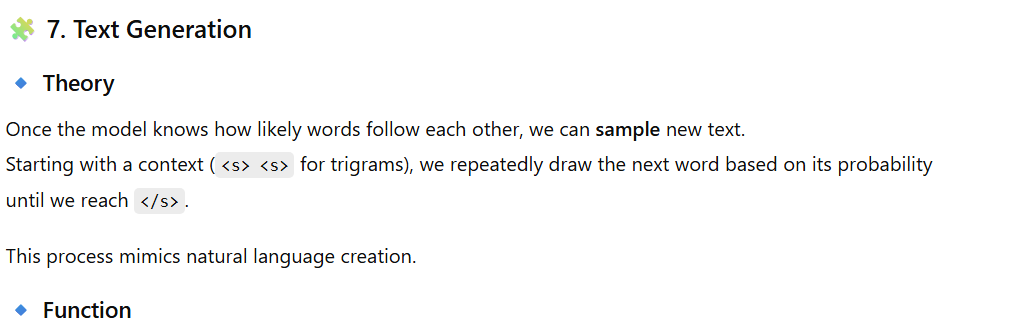

In [23]:
from typing import List, Tuple, Dict
import random

def generate_text_interpolated(
    vocab: List[str],
    uni_counts: Dict,
    bi_counts: Dict,
    tri_counts: Dict,
    uni_contexts: Dict,
    bi_contexts: Dict,
    tri_contexts: Dict,
    length: int = 20,
    lambdas: Tuple[float, float, float] = (0.1, 0.3, 0.6),
    k: float = 1.0
) -> str:
    """
    Generates text from a trigram language model using interpolated probabilities.
    """

    # Step 1: Initialize the starting context with two sentence-start tokens
    # These act as initial history for trigram generation
    context = ["<s>", "<s>"]

    # Step 2: Initialize an empty list to hold the generated words
    output = []

    # Step 3: Loop until reaching the desired number of words (length)
    for _ in range(length):
        probs = []  # list to store (word, probability) pairs

        # Step 4: For each word in the vocabulary, compute its probability
        for word in vocab:
            # Construct the trigram: last two context words + candidate next word
            ngram = tuple(context[-2:] + [word])

            # Get the interpolated probability for this trigram
            p = interpolated_probability(
                ngram,
                uni_counts, bi_counts, tri_counts,
                uni_contexts, bi_contexts, tri_contexts,
                len(vocab), lambdas, k
            )

            # Store the word and its probability
            probs.append((word, p))

        # Step 5: Normalize probabilities so they sum to 1
        total = sum(p for _, p in probs)
        probs = [(w, p / total) for w, p in probs]

        # Step 6: Randomly sample the next word, weighted by probabilities
        next_word = random.choices(
            [w for w, _ in probs],       # list of candidate words
            weights=[p for _, p in probs]  # their corresponding probabilities
        )[0]

        # Step 7: If the end-of-sentence token appears, stop generation
        if next_word == "</s>":
            break

        # Step 8: Add the chosen word to the output and update context
        output.append(next_word)
        context.append(next_word)

    # Step 9: Join generated words into a single string and return it
    return ' '.join(output)


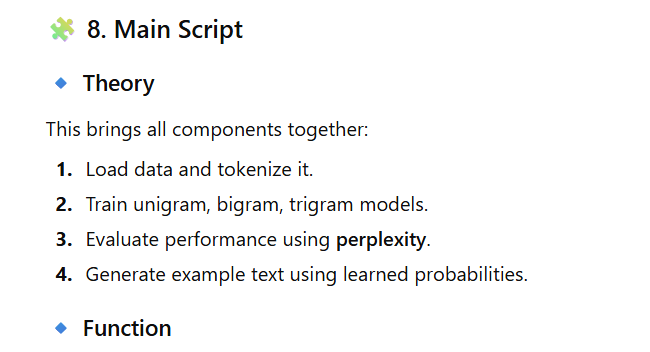

In [24]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O sample_text.txt


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
def main():
    """
    Main function:
    ----------------
    Coordinates the full language modeling pipeline:
    1. Loads and preprocesses text
    2. Trains unigram, bigram, and trigram models
    3. Evaluates models using interpolated perplexity
    4. Generates new sample text using interpolation

    Acts as a demonstration and testing harness for the n-gram model functions.
    """

    # ------------------------------------------------------------
    # 1. Load and preprocess text
    # ------------------------------------------------------------
    with open(r"D:\faculty courses\credit\NLP elective 4\Sections\input.txt", "r", encoding="utf-8") as f:
        text = f.read()

    # Tokenize the input text (split into words or symbols)
    tokens = tokenize_text(text)

    # Build the vocabulary and calculate its size
    vocab = list(set(tokens))
    vocab_size = len(vocab)

    # Split tokens into training (80%) and testing (20%) sets
    split = int(0.8 * len(tokens))
    train_tokens, test_tokens = tokens[:split], tokens[split:]

    # ------------------------------------------------------------
    # 2. Train N-gram models
    # ------------------------------------------------------------
    # Train unigram, bigram, and trigram models on the training tokens
    uni_counts, uni_ctx = train_ngram_model(train_tokens, 1)
    bi_counts, bi_ctx = train_ngram_model(train_tokens, 2)
    tri_counts, tri_ctx = train_ngram_model(train_tokens, 3)

    # ------------------------------------------------------------
    # 3. Evaluate model performance using perplexity
    # ------------------------------------------------------------
    # Use interpolated model (combining unigram + bigram + trigram probabilities)
    # Lambdas are the weights for each n-gram level
    perplexity = calculate_perplexity_interpolated(
        test_tokens,
        uni_counts, bi_counts, tri_counts,
        uni_ctx, bi_ctx, tri_ctx,
        vocab_size,
        lambdas=(0.1, 0.3, 0.6)  # weights for 1-gram, 2-gram, 3-gram
    )

    print(f"\nPerplexity: {perplexity:.2f}")

    # ------------------------------------------------------------
    # 4. Generate new text using interpolated n-gram model
    # ------------------------------------------------------------
    print("\nGenerated Text:")
    generated = generate_text_interpolated(
        vocab,
        uni_counts, bi_counts, tri_counts,
        uni_ctx, bi_ctx, tri_ctx,
        length=30,             # number of tokens to generate
        lambdas=(0.1, 0.3, 0.6)
    )
    print(generated)


# Entry point of the script
if __name__ == "__main__":
    main()



Perplexity: 2966.62

Generated Text:
profits, son? splitting sins picklock, dainty thick contributors kick'd canst; which mild, william: runaway's lodgings sweating post, men, more's hand lockram daws jested ratcliff she-wolf unnaturally renowned command loss, indifferently
